In [ ]:
# Requirements
!pip install azure-cognitiveservices-search-imagesearch==2.0.0
!pip3 install fastai==2.5.3

     |████████████████████████████████| 46 kB 2.5 MB/s 
     |████████████████████████████████| 85 kB 3.5 MB/s 
     |████████████████████████████████| 40 kB 5.5 MB/s 
     |████████████████████████████████| 41 kB 532 kB/s 
     |████████████████████████████████| 55 kB 2.8 MB/s 
     |████████████████████████████████| 3.6 MB 48.7 MB/s 
     |████████████████████████████████| 189 kB 7.4 MB/s 
     |████████████████████████████████| 56 kB 5.0 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# My Weather Dataset built using Bing Image Search API

In [ ]:
from azure.cognitiveservices.search.imagesearch import ImageSearchClient as api 
from msrest.authentication import CognitiveServicesCredentials as auth

from fastai.vision.all import *

def search_images_bing(key, term, max_images: int = 100, **kwargs):    
    params = {'q':term, 'count':max_images}
    headers = {"Ocp-Apim-Subscription-Key":key}
    search_url = "https://api.bing.microsoft.com/v7.0/images/search"
    response = requests.get(search_url, headers=headers, params=params)
    response.raise_for_status()
    search_results = response.json()    
    return L(search_results['value'])

In [ ]:
# Reference - https://weather.fandom.com/wiki/Types_of_Weather
weather_types = ['cloudy', 'snowy', 'rainy', 'windy', 'sunny'] 
path = Path('/content/drive/MyDrive/Colab Notebooks/weatherFolder')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in weather_types:
      dest = (path/o)
      dest.mkdir(exist_ok =True)
      results = search_images_bing('xxxxxxxxxx', f'{o} sky')
      download_images(dest, urls = results.attrgot('contentUrl'))


In [ ]:
files = get_image_files(path)
failed = verify_images(files)
failed.map(Path.unlink)

(#0) []

In [ ]:
# Clean EXIFs
import warnings
warnings.filterwarnings("error")

import os
from PIL import Image

subfolder = 'cloudy'
imageFolder = f'/content/drive/MyDrive/Colab Notebooks/weatherFolder/{subfolder}'
listImages = os.listdir(imageFolder)

for img in listImages:
    imgPath = os.path.join(imageFolder,img)
    try:
        if '.ipynb' not in imgPath:
            img = Image.open(imgPath)
            exif_data = img._getexif()
            img.close()
    except UserWarning as err:
        print(err)
        print("\n Error on image: ", img)

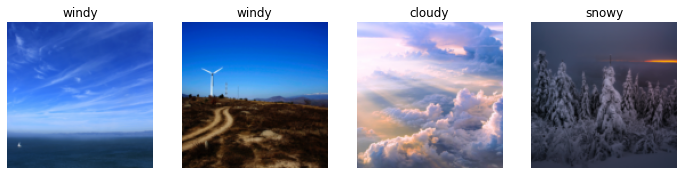

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning) 

weather = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.25, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

dls = weather.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Could not do one pass in your dataloader, there is something wrong in it


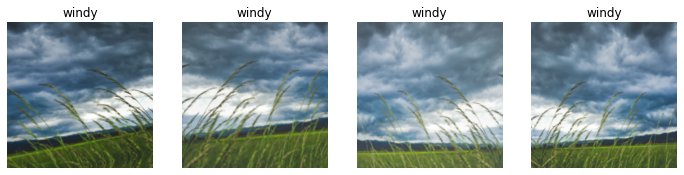

In [ ]:
weather = weather.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())  #Editable
dls = weather.dataloaders(path)  
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=error_rate, model_dir='/content/drive/MyDrive/Colab Notebooks' )
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.559872,1.864269,0.649573,01:51


Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000005.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000060.jpg' mode='rb' closefd=True>


epoch,train_loss,valid_loss,error_rate,time
0,1.709886,1.600167,0.529915,02:16
1,1.557139,1.430388,0.470085,02:18
2,1.397588,1.256724,0.393162,02:16
3,1.239449,1.196767,0.384615,02:23


Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000005.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000060.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000005.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000060.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000005.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000060.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/content/drive/MyDrive/Colab Notebooks/weatherFolder/sunny/00000060.jpg' mode='rb' closefd=True>
Exception ignored in: <_io.FileIO name='/

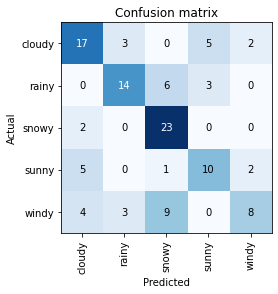

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

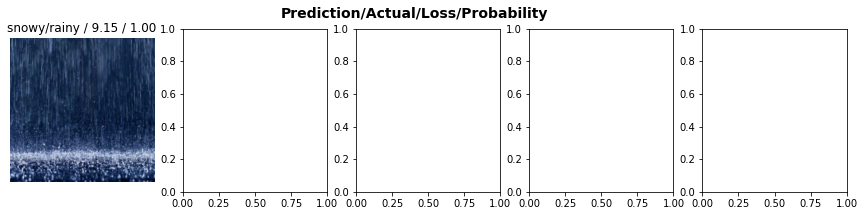

In [ ]:
interp.plot_top_losses(5, nrows=1)

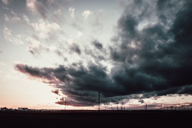

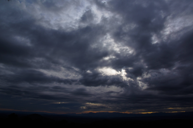

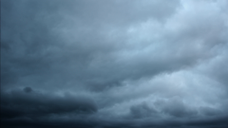

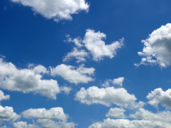

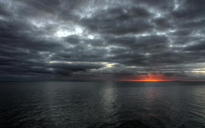

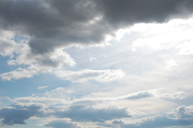

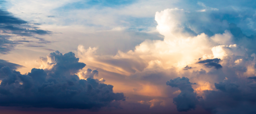

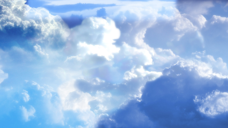

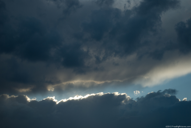

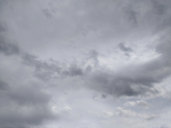

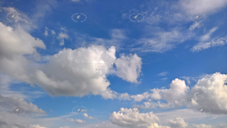

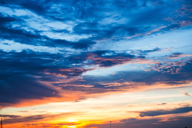

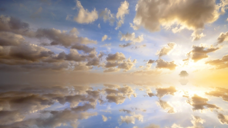

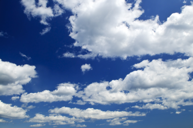

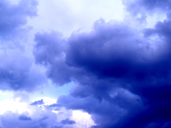

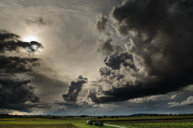

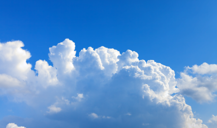

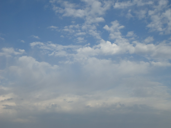

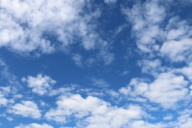

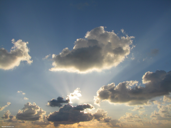

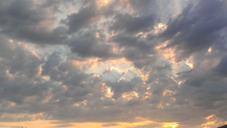

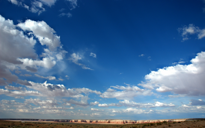

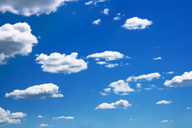

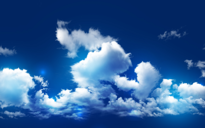

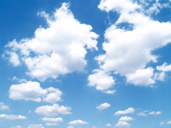

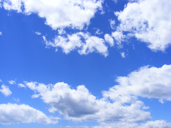

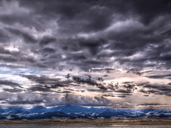

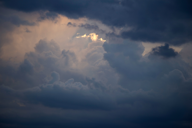

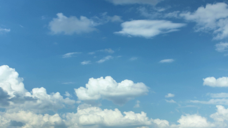

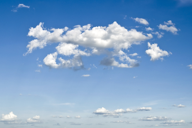

In [ ]:
from fastai.vision.widgets import ImageClassifierCleaner 
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
learn.export()

In [ ]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

('snowy', TensorBase(2), TensorBase([0.0198, 0.2485, 0.5291, 0.0022, 0.2004]))


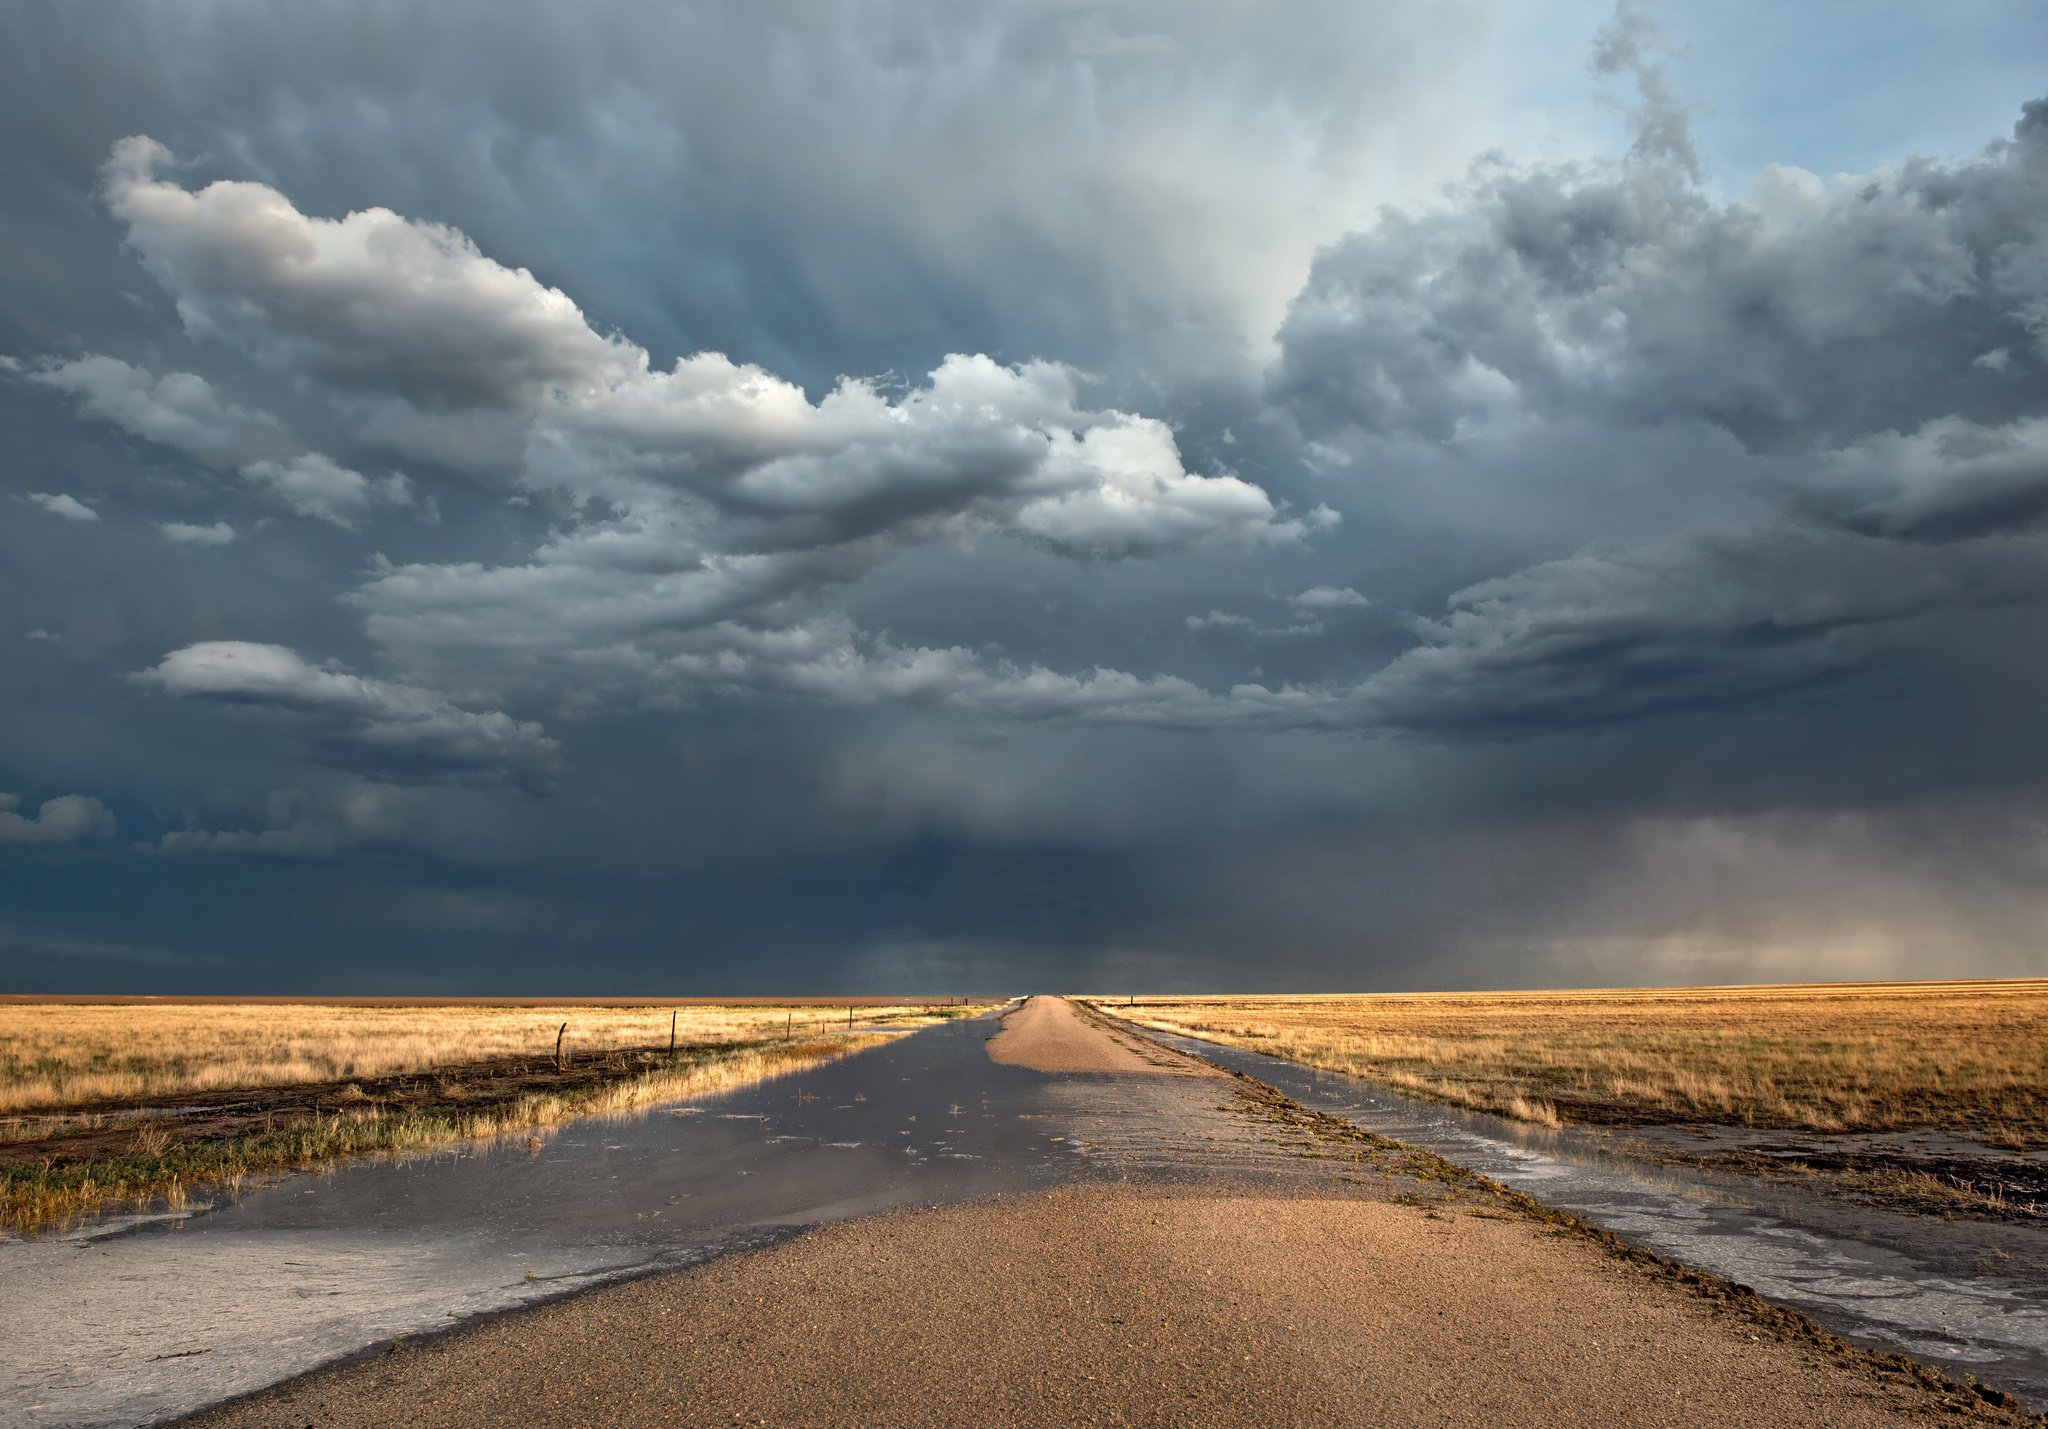

In [ ]:
from IPython.display import Image
learn_inf = load_learner(path/'export.pkl')
print(learn_inf.predict('/content/drive/MyDrive/Colab Notebooks/weatherFolder/rainy/00000000.jpg'))
Image(filename='/content/drive/MyDrive/Colab Notebooks/weatherFolder/rainy/00000000.jpg') 

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)